In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import re
from tqdm import tqdm
import string
import scipy
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sb
from wordcloud import WordCloud

In [62]:
pip install wordcloud

In [2]:
def loaddata(filename):
    col_names =["col1","col2","col3","col4","similarity","sen1","sen2"]
    return pd.read_csv(filename, sep= "\t", names=col_names, usecols=["similarity","sen1","sen2"])

train_df=loaddata('sts-train.csv')


In [3]:
train_df.head(50)

,similarity,sen1,sen2
0,5.000,A plane is taking off.,An air plane is taking off.
1,3.800,A man is playing a large flute.,A man is playing a flute.
2,3.800,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,2.600,Three men are playing chess.,Two men are playing chess.
4,4.250,A man is playing the cello.,A man seated is playing the cello.
5,4.250,Some men are fighting.,Two men are fighting.
6,0.500,A man is smoking.,A man is skating.
7,1.600,The man is playing the piano.,The man is playing the guitar.
8,2.200,A man is playing on a guitar and singing.,A woman is playing an acoustic guitar and sing...
9,5.000,A person is throwing a cat on to the ceiling.,A person throws a cat on the ceiling.


In [11]:
#Checking for Null values in any of the columns
train_df.isnull().sum()



similarity    0
sen1          0
sen2          0
dtype: int64

In [12]:
#Checking for NAs in any of the columns
train_df.isna().sum()

similarity    0
sen1          0
sen2          0
dtype: int64

In [5]:
#3 Null values are present in the sen2 field. 
#The null values are in the column, sentence2 which cannot be estimated with any of the missing values estimation strategies. Hence we will be dropping those 3 rows as we cannot further process those records.
train_df = train_df.dropna(subset=["sen2"])

In [6]:
#Checking full Null values in any of the columns after dropping NAs 
train_df.isnull().sum()

similarity    0
sen1          0
sen2          0
dtype: int64

In [9]:
#Checking the data integrety
#the similarity score should be between 0 and 5. If the similarity scores is beyond 0 and 5 then the similarity score is invalid
cnt = [cnt+1 for i in train_df['similarity'] if i<0 or i > 5]
print("Number of values falling outisde the similarity score boundaries are: ", cnt)

Number of values falling outisde the similarity score boundaries are:  []


In [13]:
#Decribing the similarity field
print(train_df["similarity"].describe())

count    5708.000000
mean        2.698560
std         1.466428
min         0.000000
25%         1.500000
50%         3.000000
75%         3.800000
max         5.000000
Name: similarity, dtype: float64


In [14]:
#Describing the sen1 and sen2 which are sentence1 and sentence2 
print(train_df["sen1"].value_counts())


A man is playing a guitar.                                                16
A woman is slicing an onion.                                               8
A woman is peeling a potato.                                               7
A man is playing guitar.                                                   7
A man is playing the guitar.                                               7
                                                                          ..
A woman peels shrimp.                                                      1
4 Killed in US Drone Strike in Pakistan                                    1
The procedure is generally performed in the second or third trimester.     1
A man is looking at a computer monitor.                                    1
A man is talking with a woman.                                             1
Name: sen1, Length: 5395, dtype: int64


We can see that there are few sentences which are repeated multiple times

In [15]:
#Describing the sen1 and sen2 which are sentence1 and sentence2 
print(train_df["sen2"].value_counts())

A man is playing a guitar.                                                                                                                        23
A man is playing a flute.                                                                                                                          8
A man is dancing.                                                                                                                                  6
A man is driving a car.                                                                                                                            6
A woman is dancing.                                                                                                                                5
                                                                                                                                                  ..
Palestinians' first ever UN vote symbolic yet historic                                                    

We can see that there are few sentences which are repeated multiple times

In [16]:
#Obtaining more statistical information about the similarity scores
print("Printing the frequency of similarity scores\n ", train_df['similarity'].astype(int).value_counts())

Printing the frequency of similarity scores
  3    1572
4    1131
2     974
0     889
1     877
5     265
Name: similarity, dtype: int64


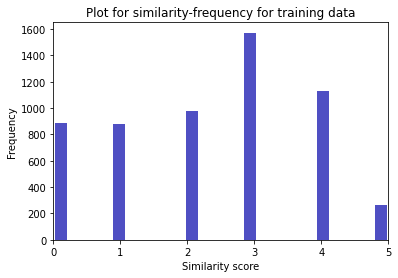

In [19]:
#An histogram showing the distribution of the similarity scores
n, bins, patches = plt.hist(train_df["similarity"].astype(int), bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('Similarity score')
plt.ylabel('Frequency')
plt.title('Plot for similarity-frequency for training data')
plt.xlim(0, 5)
#plt.grid(True)
plt.show()

In [20]:
#Importing contractions
from pycontractions import Contractions
cont = Contractions(api_key="glove-twitter-100")
cont.load_models()

In [21]:
#Defining Function for Expanding contractions
def contraction_removal(record):
    global cont
    corrections = list(cont.expand_texts([record["sen1"]], precise=True))
    record["sen1"] = corrections[0]
    corrections = list(cont.expand_texts([record["sen2"]], precise=True))
    record["sen2"] = corrections[0]
    return record

In [22]:
train_df = train_df.apply(contraction_removal,axis=1)

In [78]:
#Defining a wrapper function to correct the spellings of the words
from autocorrect import Speller
def spell_check_eng(record):
    check = Speller(lang='en')
    record["sen1"] = check(record["sen1"])
    record["sen2"] = check(record["sen2"])
    return record

In [79]:
#Applying the wrapper function to spell check the words and update the spellings accordingly
train_df = train_df.apply(spell_check_eng,axis=1)

In [2]:
import warnings
warnings.filterwarnings('ignore')
#Importing segmenter function from ekphrasis package
from ekphrasis.classes.segmenter import Segmenter
# segmenter using the word statistics from english Wikipedia
seg_eng = Segmenter(corpus="english") 

#Defining word segmentation function
def word_segmentation(record):
    global seg_eng
    record["sen1"] = seg_eng.segment(record["sen1"])
    record["sen2"] = seg_eng.segment(record["sen2"])
    return record

Reading english - 1grams ...
Reading english - 2grams ...


In [24]:
train_df = train_df.apply(word_segmentation, axis = 1)

In [25]:
#Defining function to remove punctuations in the sentences
def punc_remove_wrapper(record, maxlen=None):
    puncts = [
         ',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&',
        '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
        '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',
        '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '“', '★', '”',
        '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾',
        '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼', '⊕', '▼',
        '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
        'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»',
        '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø',
        '¹', '≤', '‡', '√', '«', '»', '´', 'º', '¾', '¡', '§', '£', '₤']
    no_punc_sen1 = record["sen1"]
    no_punc_sen2 = record["sen2"]
    for punct in puncts:   
        if punct in record["sen1"] or punct in record["sen2"]:
            no_punc_sen1= no_punc_sen1.replace(punct, '')
            no_punc_sen2 = no_punc_sen2.replace(punct,'')
    record["sen1"] = no_punc_sen1
    record["sen2"] = no_punc_sen2
    return record

In [26]:
train_df = train_df.apply(punc_remove_wrapper, axis = 1)

In [27]:
#Removing the stop words in the sentences as they don't have much importance when calculating the similarity score
stop_words = set(stopwords.words('english'))

In [28]:
train_df["sen1"] = train_df["sen1"].apply(lambda x: " ".join([w for w in str(x).lower().split() if w not in stop_words]))
train_df["sen2"] = train_df["sen2"].apply(lambda x: " ".join([w for w in str(x).lower().split() if w not in stop_words]))

In [73]:
train_df.head(5)

,similarity,sen1,sen2,sen1_tokens,sen2_tokens,sen1_count,sen2_count,similarity_round,different_words
0,5.00,plane taking,air plane taking,"[plane, taking]","[air, plane, taking]",2,3,5,0
1,3.80,man playing large flute,man playing flute,"[man, playing, large, flute]","[man, playing, flute]",4,3,3,1
2,3.80,man spreading shreded cheese pizza,man spreading shredded cheese uncooked pizza,"[man, spreading, shreded, cheese, pizza]","[man, spreading, shredded, cheese, uncooked, p...",5,6,3,1
3,2.60,three men playing chess,two men playing chess,"[three, men, playing, chess]","[two, men, playing, chess]",4,4,2,1
4,4.25,man playing cello,man seated playing cello,"[man, playing, cello]","[man, seated, playing, cello]",3,4,4,0


In [74]:
#Wrapper function to tokenize data in sentence1 and sentence2
def tokenize_wrapper(record):
    sen1_tokens = word_tokenize(record["sen1"])
    sen2_tokens = word_tokenize(record["sen2"])
    record["sen1_tokens"]= sen1_tokens
    record["sen2_tokens"] = sen2_tokens
    return record

In [34]:
train_df["sen1_tokens"] = ""

In [35]:
train_df["sen2_tokens"] = ""

In [36]:
train_df = train_df.apply(tokenize_wrapper, axis=1)

In [37]:
# defining an wrapper function to get the word counts in the sentences after perfomring the data cleaning operation on the sentences
def get_word_count(string):
    return len(string.split())

In [41]:
#Obatining the word count in the columns sen1 and sen2 to see if there is any pattern in the number of words and similarity score
train_df["sen1_count"] = train_df["sen1"].apply(get_word_count)
train_df["sen2_count"] = train_df["sen2"].apply(get_word_count)

In [44]:
#performing the correlation tests between the sen1 word count and sen2 word count to confirm the obvious correlataion between the sentences
train_df[["sen1_count","sen2_count","similarity"]].corr(method="spearman")

,sen1_count,sen2_count,similarity
sen1_count,1.000000,0.824952,0.195672
sen2_count,0.824952,1.000000,0.198960
similarity,0.195672,0.198960,1.000000


We can clearly observe that there is a high degree of corelation between the word counts of both the sentences. Also we can notice that there is very weak correlation between the similarity score and the number of words in the sentences.

In [53]:
train_df["similarity_round"] = train_df["similarity"].astype(int)

Text(0.5, 1.0, 'Similairy Score Vs Number of words in Senence1')

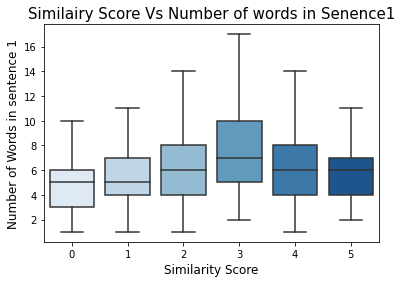

In [61]:
#Boxplot showing the number of words and the similarity score for both sentence1 and sentence2
sb.boxplot(x='similarity_round', y='sen1_count', data=train_df, palette="Blues",showfliers=False)
plt.xlabel("Similarity Score", fontsize= 12)
plt.ylabel("Number of Words in sentence 1", fontsize= 12)
plt.title("Similairy Score Vs Number of words in Senence1", fontsize= 15)

Text(0.5, 1.0, 'Similairy Score Vs Number of words in Senence2')

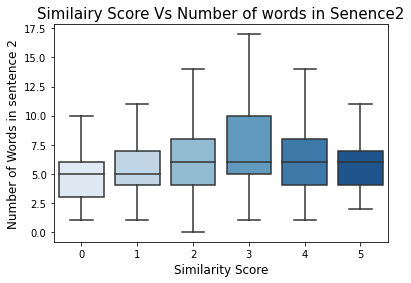

In [60]:
#Boxplot showing the number of words and the similarity score for both sentence1 and sentence2
sb.boxplot(x='similarity_round', y='sen2_count', data=train_df, palette="Blues",showfliers=False)
plt.xlabel("Similarity Score", fontsize= 12)
plt.ylabel("Number of Words in sentence 2", fontsize= 12)
plt.title("Similairy Score Vs Number of words in Senence2", fontsize= 15)

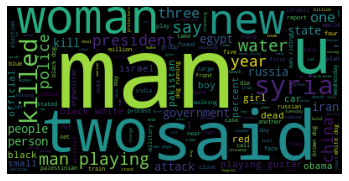

In [64]:
#After performing the necessary data cleaning steps and removing stop words, let's see what are most frquent words in all the senteces
wordcloud = WordCloud().generate(' '.join(train_df['sen1']))
# Generate plot
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

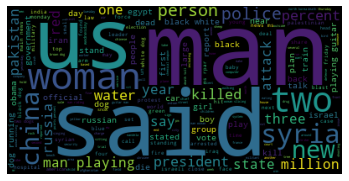

In [65]:
wordcloud = WordCloud().generate(' '.join(train_df['sen2']))
# Generate plot
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [66]:
#Wrting a function to see how may different words are between sentence1 and sentence2 and to see how similarity effects with the number
def get_different_words_count(record):
    sen1_len = record["sen1_count"]
    sen2_len = record["sen1_count"]
    count = 0
    for word in record["sen1_tokens"]:
        if word in record["sen2_tokens"]:
            count = count + 1
    different_words = max(sen1_len, sen2_len) - count
    return different_words

In [68]:
train_df["different_words"] = train_df.apply(get_different_words_count, axis=1)

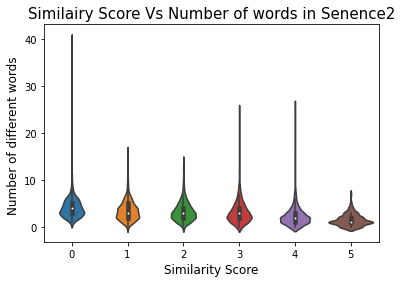

In [77]:
#Plotting the scatter plot between different words in both the sentences and the similarity score 
sb.violinplot(x="similarity_round", y="different_words", data=train_df, showfliers=False)
plt.xlabel("Similarity Score", fontsize= 12)
plt.ylabel("Number of different words ", fontsize= 12)
plt.title("Similairy Score Vs Number of words in Senence2", fontsize= 15)
plt.show()

In [57]:
#Embedding vector models
import gensim
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec

word2vec = gensim.models.KeyedVectors.load_word2vec_format("D:/Softwares/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin", binary=True)

KeyboardInterrupt: 

In [20]:
tempfile = "D:/Softwares/embeddings/glove.840B.300d/glove_word2Vec.txt"
#glove2word2vec("D:/Softwares/embeddings/glove.840B.300d/glove.840B.300d.txt",tempfile)
glove = gensim.models.KeyedVectors.load_word2vec_format(tempfile)

In [32]:

def average_feature_vector(s, model, feature_num, index_set):
    words = s.split()
    feature_vec = np.zeros((feature_num, ), dtype='float32')
    n_words = 0
    for word in words:
        if word in index_Set:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

In [33]:
from scipy import spatial
def cosine_similarity_score(s1, s2, model):
    s1_average_feature_vector = average_feature_vector('this is a sentence', model=model, num_features=300, index2word_set=index2word_set)
    s2_average_feature_vector = average_feature_vector('this is also sentence', model=model, num_features=300, index2word_set=index2word_set)
    cosine_sim = 1 - spatial.distance.cosine(s1_average_feature_vector, s2_average_feature_vector)
    return cosine_sim


In [22]:
def word_movers_similarity_score(s1,s2,model):
    model.init_sims(replace=True)
    distance = model.wmdistance(s1,s2)
    return distance